## Genetic Algorithms
Naively mimicking nature evolution. Generally used to generate high-quality solutions to optimization and search problems.
Here I'll try to implement three variants of the method, basic fitness based probability, fitness ranked individuals probability and fitnes + diversity ranked individuals.

<p align="center">
    <img src=".\images\ga_pipeline.png" alt="ga" width="300"/>
</p>

### Function Maximization Example

<p align="center">
    <img src=".\images\surface.png" alt="ga" width="200"/>
</p>

In [1]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colormaps
from matplotlib.colors import LightSource

In [2]:
ls = LightSource(270, 45)

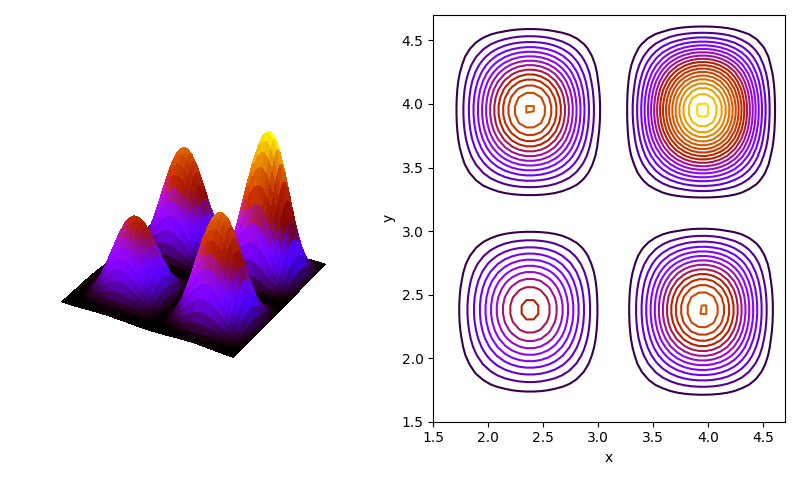

In [3]:
n = 50
x = np.linspace(1.5, 4.7, n)
y = x.copy()
x, y = np.meshgrid(x, y)

z = np.sin(2*x)**2 * np.sin(2*y)**2 * np.exp((x+y)/5)

fig = plt.figure(figsize=plt.figaspect(.6))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
rgb = ls.shade(z, cmap=colormaps["gnuplot"], vert_exag=0.1, blend_mode='soft')

surf = ax1.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)
ax1.axis("off")

ax2 = fig.add_subplot(1, 2, 2)
ax2.contour(x, y, z, levels=20, cmap=colormaps["gnuplot"])
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.tight_layout()
plt.show()

* **Pseudocode**:
1. Initial population: set of $(x, y)$ values such that $x \in [x_{\text{min}}, x_{\text{max}}]$ (idem for $y$)
1. Fitness: $f(x, y)$
1. Selection: Select $k$ (hyperparamenters) that will be eligible for crossover as parents
1. Crossover: Out of the $k$ individuals they are recombined in pairs and, using another hyperparameter $C_p$, they will be crossover or simple pass a copy of the parents as children.
1. Mutation: Small modification of a given individual (bits chunks, step size, ...) also controled by a probability $M_p$.
1. Terminate or loop back

In [4]:
class MaximizeFunction:
    def __init__(self, x_range, y_range, n_pop=1, n_iter=100, animate=False, verbose=False):
        self.n_pop = n_pop
        self.n_iter = n_iter
        self.animate = animate
        self.verbose = verbose
        self.population = None

        assert x_range[0] < x_range[1], "Check x range"
        assert y_range[0] < y_range[1], "Check y range"
        self.x_range = x_range
        self.y_range = y_range

        self.init_population()

        if self.animate:
            self.populations = [self.population.copy()]
    
    def init_population(self):
        self.population = np.empty((self.n_pop, 2))
        self.population[:, 0] = np.random.uniform(*self.x_range, size=self.n_pop)
        self.population[:, 1] = np.random.uniform(*self.y_range, size=self.n_pop)
    
    def fitness(self, x, y):
        return np.sin(2*x)**2 * np.sin(2*y)**2 * np.exp((x+y)/5)
    
    def score(self):
        return np.array([self.fitness(*p) for p in self.population])

    def selection(self):
        """Fitness proportionate selection.
        
        Cumulative probability produces the appropriate framework to a simple selection
        method, take a random number and the selected candidate will be the first cumulative
        probability range such that n < cp.

        TODO: Ranked fitness selection method; Ranked fitness + diversity selection method.
        """
        scores = self.score()
        cumulative_probs = np.cumsum(scores / scores.sum())
        mask = np.random.rand() < cumulative_probs
        
        return self.population[np.argwhere(mask).flatten()[0]]


    def select_parents(self):
        return np.array([self.selection() for _ in range(self.n_pop)])
    
    def crossover(self, parent_a, parent_b, c_prob=0.8):
        new_parent_a = parent_a.copy()
        new_parent_b = parent_b.copy()

        if np.random.rand() < c_prob:
            new_parent_a[1] = parent_b[1]
            new_parent_b[0] = parent_a[0]
            
        return new_parent_a, new_parent_b

    def mutate(self, individual, step=.05, m_prob=0.05):
        """TODO: check if they go out the grid"""
        x = individual[0]
        y = individual[1]
        if np.random.rand() < m_prob:
            x += step * np.random.choice([1, 0, -1])
            y += step * np.random.choice([1, 0, -1])
        return np.array([x, y])


    def new_generation(self):
        parents = self.select_parents()
        new_population = []

        for i in range(0, self.n_pop, 2):
            # crossover
            p1, p2 = self.crossover(parents[i], parents[i+1])
            # mutation
            new_population.append(self.mutate(p1))
            new_population.append(self.mutate(p2))
        return np.array(new_population)
    
    def update_population(self):
        self.population = self.new_generation()
    
    def run(self):
        print("Genetic Algorithm for function maxima search.")

        initial_score = self.score()
        best_ind, best_score = np.argmax(initial_score), initial_score.max()
        if self.verbose:
            print("-- Generation: 0")
            print(f"Best individual: {self.population[best_ind]}; Score: {best_score:.2f}")
        for gen in range(1, self.n_iter + 1):
            if self.verbose:
                print("-- Generation: ", gen)
            self.update_population()

            if self.animate:
                self.populations.append(np.unique(self.population.copy(), axis=1))

            current_score = self.score()
            new_best_ind, new_best_score = np.argmax(current_score), current_score.max()
            if new_best_score > best_score:
                best_ind = new_best_ind
                best_score = new_best_score
            if self.verbose:
                print(f"Best individual: {self.population[best_ind]}; Score: {best_score:.2f}")

a = MaximizeFunction([1.5, 4.7], [1.5, 4.7], n_pop=100, n_iter=50, animate=True, verbose=False)
a.run()



Genetic Algorithm for function maxima search.


### Optimization Animation

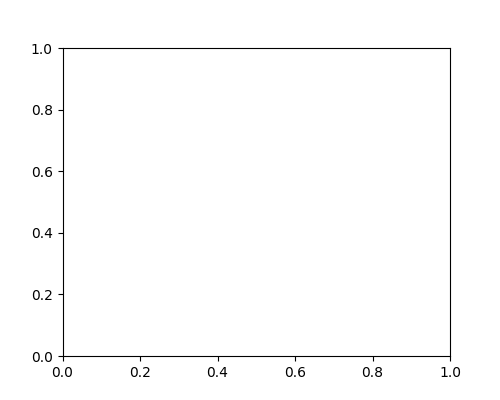

In [7]:
from optimization_animate import animate_search

matplotlib.pyplot.close("all")


n = 50
x = np.linspace(1.5, 4.7, n)
y = x.copy()
x, y = np.meshgrid(x, y)

z = np.sin(2*x)**2 * np.sin(2*y)**2 * np.exp((x+y)/5)

fig, ax = plt.subplots(figsize=(5, 4))

anim = animate_search(fig, ax, "Surface maximum", [x, y, z], a.populations, interval=100)

plt.show()

### Readme GIF

In [8]:
import matplotlib.animation as animation

writer = animation.PillowWriter(
    fps=2,
    bitrate=1800,
)

anim.save(
    f"./gifs/genetic_algorithm.gif",
    writer=writer,
    dpi=150
)